<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#利用slim实现inception-v3的Mixed-7c模块" data-toc-modified-id="利用slim实现inception-v3的Mixed-7c模块-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>利用slim实现inception-v3的Mixed-7c模块</a></span></li><li><span><a href="#疑问点" data-toc-modified-id="疑问点-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>疑问点</a></span><ul class="toc-item"><li><span><a href="#以下代码的含义" data-toc-modified-id="以下代码的含义-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>以下代码的含义</a></span></li></ul></li></ul></div>

# 利用slim实现inception-v3的Mixed-7c模块


模块结构如下:

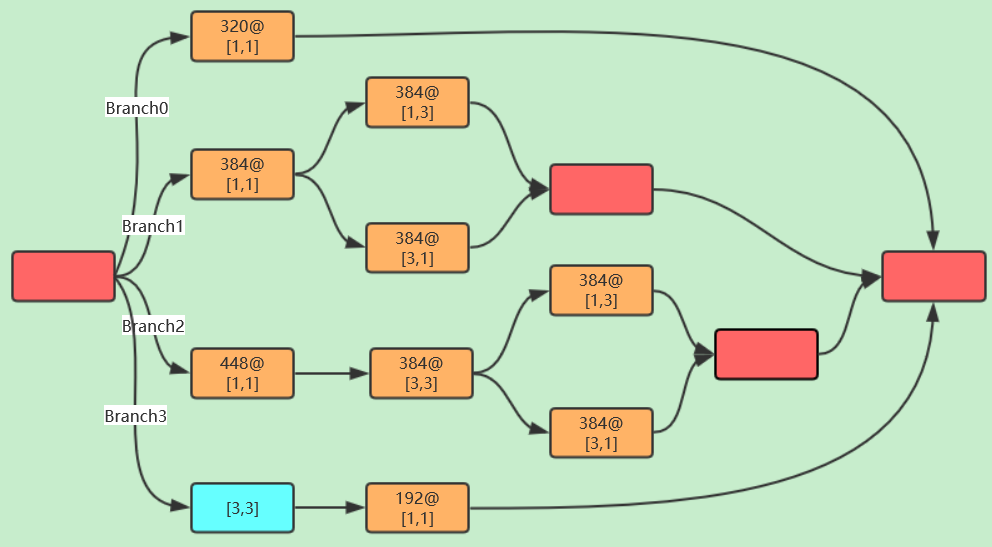

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.contrib import layers
from tensorflow.contrib.framework.python.ops import arg_scope
from tensorflow.contrib.layers.python.layers import layers as layers_lib
from tensorflow.contrib.layers.python.layers import regularizers
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import variable_scope

trunc_normal = lambda stddev: init_ops.truncated_normal_initializer(0.0, stddev)

In [ ]:
def inception_v3_base(inputs, final_endpoint='Mixed_7c',min_depth=16,
                     depth_multiplier=1.0, scope=None)
'''
    Inception model from http://arxiv.org/abs/1512.00567.

    Constructs an Inception v3 network from inputs to the given final endpoint.
    This method can construct the network up to the final inception block
    Mixed_7c.

    Note that the names of the layers in the paper do not correspond to the names
    of the endpoints registered by this function although they build the same
    network.
    
    Here is a mapping from the old_names to the new names:
    Old name          | New name
    =======================================
    conv0             | Conv2d_1a_3x3
    conv1             | Conv2d_2a_3x3
    conv2             | Conv2d_2b_3x3
    pool1             | MaxPool_3a_3x3
    conv3             | Conv2d_3b_1x1
    conv4             | Conv2d_4a_3x3
    pool2             | MaxPool_5a_3x3
    mixed_35x35x256a  | Mixed_5b
    mixed_35x35x288a  | Mixed_5c
    mixed_35x35x288b  | Mixed_5d
    mixed_17x17x768a  | Mixed_6a
    mixed_17x17x768b  | Mixed_6b
    mixed_17x17x768c  | Mixed_6c
    mixed_17x17x768d  | Mixed_6d
    mixed_17x17x768e  | Mixed_6e
    mixed_8x8x1280a   | Mixed_7a
    mixed_8x8x2048a   | Mixed_7b
    mixed_8x8x2048b   | Mixed_7c
'''

# end_points will collect relevant activations for external use, for example
# summaries or losses.
end_points = {}

if depth_multiplier <= 0:
    raise ValueError('depth_multiplier is not greater than zero.')
depth = lambda d: max(int(d * depth_multiplier), min_depth)

with variable_scope.variable_scope(scope, 'InceptionV3', [inputs]):
    # 构建conv0-conv1-conv2-pool1-conv3-conv4-pool2的结构
    with arg_scope([layers.conv2d, layers_lib.max_pool2d, 
                    layers_lib.avg_pool2d], stride=1, padding='VALID'):
        # 299 x 299 x 3
        end_point = 'Conv2d_1a_3x3'
        net = layers.conv2d(inputs, depth(32), [3, 3], stride=2, scope=end_point)
        end_points[end_point] = net
        if end_point == final_endpoint:
            return net, end_points
        
        # 149*149*32
        end_point = 'Conv2d_2a_3x3'
        net = layers.conv2d(net, depth(32), [3, 3], scope=end_point)
        end_points[end_point] = net
        if end_point == final_endpoint:
            return net, end_points
        
        # 147*147*32
        end_point = 'Conv2d_2b_3x3'
        net = layers.conv2d(net, depth(64), [3, 3], padding='SAME', scope=end_point)
        end_points[end_point] = net
        if end_point == final_endpoint:
            return net, end_points
        
        # 147*147*64
        end_point = 'MaxPool_3a_3x3'
        net = layers_lib.max_pool2d(net, [3, 3], stride=2, scope=end_point)
        end_points[end_point] = net
        if end_point == final_endpoint:
            return net, end_points
        
        # 73 x 73 x 64
        end_point = 'Conv2d_3b_1x1'
        net = layers.conv2d(net, depth(80), [1, 1], scope=end_point)
        end_points[end_point] = net
        if end_point == final_endpoint:
            return net, end_points
        
        # 73 x 73 x 80.
        end_point = 'Conv2d_4a_3x3'
        net = layers.conv2d(net, depth(192), [3, 3], scope=end_point)
        end_points[end_point] = net
        if end_point == final_endpoint:
            return net, end_points
      
        # 71 x 71 x 192.
        end_point = 'MaxPool_5a_3x3'
        net = layers_lib.max_pool2d(net, [3, 3], stride=2, scope=end_point)
        end_points[end_point] = net
        if end_point == final_endpoint:
            return net, end_points
        # 35 x 35 x 192.
        
        # Inception blocks
        with arg_scope([layers.conv2d, layers_lib.max_pool2d, 
                        layers_lib.avg_pool2d], stride=1, padding='SAME'):
            # 省略其他模块
            # 构造'Mixed_7c模块'
            # mixed_10: 8 x 8 x 2048
            end_point = 'Mixed_7c'
            with variable_scope.variable_scope('end_point'):
                with variable_scope.variable_scope('Branch_0'):
                    branch_0 = layers.conv2d(net, depth(320), [1, 1], scope='Conv2d_0a_1x1')

                with variable_scope.variable_scope('Branch_1'):
                    branch_1 = layers.conv2d(net, depth(384), [1, 1], scope='Conv2d_0a_1x1')
                    branch_10 = layers.conv2d(branch_1, depth(384), [1, 3], scope='Conv2d_0b_1x3')
                    branch_11 = layers.conv2d(branch_1, depth(384), [3, 1], scope='Conv2d_0c_3x1')
                    branch_1 = array_ops.concat([branch_10, branch_11], 3)

                with variable_scope.variable_scope('Branch_2'):
                    branch_2 = layers.conv2d(net, depth(448), [1, 1], scope='Conv2d_0a_1x1')
                    branch_2 = layers.conv2d(branch_2, depth(384), [3, 3], scope='Conv2d_0b_3x3')
                    branch_20 = layers.conv2d(branch_2, depth(384), [1, 3], scope='Conv2d_0c_1x3')
                    branch_21 = layers.conv2d(branch_2, depth(384), [3, 1], scope='Conv2d_0d_3x1')
                    branch_2 = array_ops.concat([branch_20, branch_21], axis=3)

                with variable_scope.variable_scope("Branch_3"):
                    branch_3 = layers_lib.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                    branch_3 = layers.conv2d(net, [3, 3], scope='Conv2d_0b_1x1')
            
                # 综合模块
                net = array_ops.concat([branch_0, branch_1, branch_2, branch_3], axis=3)
            
            # 添加当前模块的数据
            end_points[end_point] = net
            
            if end_point == final_endpoint:
                return net, end_point
            
        return ValueError('Unknown final endpoint %s', % final_endpoint)

# 疑问点

## 以下代码的含义

```
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
```

**from __future__ import absolute_import**

关于这句from __future__ import absolute_import的作用: 
直观地看就是说”加入绝对引入这个新特性”。说到绝对引入，当然就会想到相对引入。那么什么是相对引入呢?比如说，你的包结构是这样的: 
pkg/ 
pkg/init.py 
pkg/main.py 
pkg/string.py

如果你在main.py中写import string,那么在Python 2.4或之前, Python会先查找当前目录下有没有string.py, 若找到了，则引入该模块，然后你在main.py中可以直接用string了。如果你是真的想用同目录下的string.py那就好，但是如果你是想用系统自带的标准string.py呢？那其实没有什么好的简洁的方式可以忽略掉同目录的string.py而引入系统自带的标准string.py。这时候你就需要from __future__ import absolute_import了。这样，你就可以用import string来引入系统的标准string.py, 而用from pkg import string来引入当前目录下的string.py了

**from __future__ import division**

导入python未来支持的语言特征division(精确除法)，当我们没有在程序中导入该特征时，"/"操作符执行的是截断除法(Truncating Division),当我们导入精确除法之后，"/"执行的是精确除法，如下所示：

```
>>> 3/4
0
>>> from __future__ import division
>>> 3/4
0.75
```

**from __future__ import print_function**

在开头加上from __future__ import print_function这句之后，即使在python2.X，使用print就得像python3.X那样加括号使用。python2.X中print不需要括号，而在python3.X中则需要

如果某个版本中出现了某个新的功能特性，而且这个特性和当前版本中使用的不兼容，也就是它在该版本中不是语言标准，那么我如果想要使用的话就需要从future模块导入。